# Linear + Non-linear Regression

## Imports

In [130]:
import numpy as np
import pandas as pd 
import seaborn as sns
sns.set_style('darkgrid')
import sklearn

In [131]:
df = pd.read_csv('../webscraping/moonboard_data.csv', index_col=0)
df = df.dropna()
df = df.query("angle == 40")
df.head()

,holds,grades,year,angle
0,"[('A18', 'end'), ('C10', 'hold'), ('D15', 'hol...",7B,2016,40
1,"[('E18', 'end'), ('F13', 'hold'), ('G6', 'star...",7B,2016,40
2,"[('E18', 'end'), ('F14', 'hold'), ('F9', 'hold...",7B,2016,40
3,"[('B3', 'start'), ('E10', 'hold'), ('F7', 'hol...",7B,2016,40
4,"[('D10', 'hold'), ('H18', 'end'), ('H14', 'hol...",7B,2016,40


<Axes: xlabel='grades', ylabel='Count'>

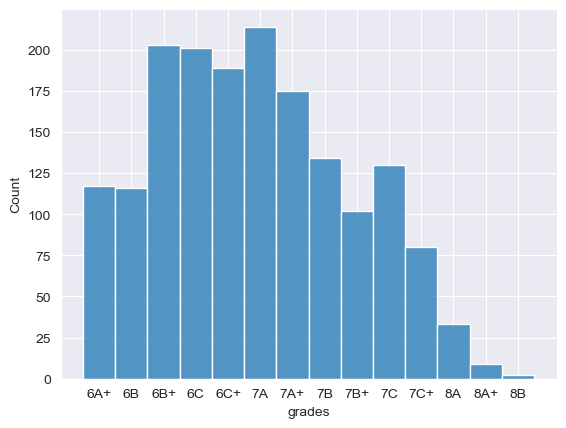

In [132]:
sns.histplot(data=df.sort_values('grades'), x='grades')

## Encoding holds as dictionary
Here we create a custom transformer which:
- drops null values from the `DataFrame`
- parses the string of holds into a list of holds
- encodes holds as a dictionary we can pass to `DictVectorizer`

In [133]:
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin 
from typing import List

class DictEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X: pd.DataFrame, y=None):
        return self
    
    def parseList(self, holdlist: List[str]):
        """ Parses a list of holds into a dicionary of the form {hold : 1} """
        return {hold : 1 for hold, color in holdlist}
    
    def transform(self, X: pd.DataFrame):
        """
        Encodes a list of holds into a dictionary of key, value pairs where
        each key is a hold of the form [column index A-K][row index 1-18]
        and each value is 1
        """
        X = X.dropna() # first drop missing values (problem no longer exists)
        X['holds'] = X['holds'].apply(lambda holdlist: self.parseList(eval(holdlist))) # parse strings to list of holds
        return X['holds']

In [134]:
from numpy import ndarray
from sklearn.base import BaseEstimator 
from sklearn.base import TransformerMixin 

class LabelEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X: pd.DataFrame, y=None):
        return self
    
    def grade_to_number(self, grade: str) -> int:
        """ Maps a route's grade to an integer """
        grade_dict = {
            '5+' : 0,
            '6A' : 1,
            '6A+' : 2,
            '6B' : 3,
            '6B+' : 4,
            '6C' : 5,
            '6C+' : 6,
            '7A' : 7,
            '7A+' : 8,
            '7B' : 9,
            '7B+' : 10,
            '7C' : 11,
            '7C+' : 12,
            '8A' : 13,
            '8A+' : 14,
            '8B' : 15,
            '8B+' : 16,
            '8C' : 17,
            '8C+' : 18
        }
        if grade not in grade_dict:
            raise Exception(f"Invalid Grade! {grade}")
        else:
            return grade_dict[grade]
    
    def transform(self, X: pd.DataFrame):
        """ Maps the `grades` column of a `DataFrame` to its numeric value (to be scaled) """
        X = X.dropna()
        X['grades_numeric'] = X['grades'].apply(self.grade_to_number) # parse grades to numeric value
        return X[['grades_numeric']]

## Custom Linear + Non-linear regression

In [135]:
from sklearn.linear_model import Ridge 
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin 
from sklearn.metrics import r2_score

class CustomRegression(BaseEstimator, TransformerMixin):
    def __init__(self, alpha: float = 1., n_estimators: int = 100, min_samples_leaf: int = 2) -> None:
        # Linear and nonlinear models
        self.alpha = alpha
        self.n_estimators = n_estimators
        self.min_samples_leaf = min_samples_leaf
        self.lm = Ridge(alpha = self.alpha)
        self.nlm = RandomForestRegressor(n_estimators=self.n_estimators, min_samples_leaf=self.min_samples_leaf)
        return 
        
    def fit(self, X, y):
        """
        Fits y to X with a linear model, then fits the residuals of y with a nonlinear model
        """
        y = np.ravel(y)
        self.lm.fit(X, y)
        residuals = y - self.lm.predict(X) # subtract off prediction to get residuals
        self.nlm.fit(X, residuals)
        return self
    
    def predict(self, X):
        linear_result = np.reshape(self.lm.predict(X), (-1, 1))
        non_linear_result = np.reshape(self.nlm.predict(X), (-1, 1))
        self.preds = linear_result + non_linear_result
        return self.preds
    
    def score(self, X, y):
        self.preds = self.predict(X)
        return r2_score(y, self.preds)

## Vectorize features using `DictVectorizer`

## Build `Pipeline` to vectorize holds as feature matrix

We'll also try `Ridge` regression on the features to figure out how good the model is

In [136]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline 
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import Ridge

label_pipeline = Pipeline([
    ('encoder', LabelEncoder()),
    ('scaler', StandardScaler())
])

non_linear_model = Pipeline([
    ('encoder', DictEncoder()),
    ('vectorizer', DictVectorizer()),
    ('model', CustomRegression())
])

## Grid Search: Tuning `non_linear_model` hyperparameters

In [137]:
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import train_test_split 

df_40 = df.query("angle == 40")
df_40 = df_40.sample(frac=1)

param_grid = {'model__alpha' : [4],
              'model__n_estimators' : [10],
              'model__min_samples_leaf': [1, 10, 100]}

search = GridSearchCV(non_linear_model, param_grid, cv=3)
search.fit(df_40, label_pipeline.fit_transform(df_40))
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.526):
{'model__alpha': 4, 'model__min_samples_leaf': 100, 'model__n_estimators': 10}


In [138]:
search.cv_results_

{'mean_fit_time': array([1.25683037, 1.23504806, 1.23117924]),
 'std_fit_time': array([0.00291861, 0.0108063 , 0.00773262]),
 'mean_score_time': array([0.04746707, 0.04666503, 0.04645848]),
 'std_score_time': array([0.00048451, 0.00074517, 0.00033188]),
 'param_model__alpha': masked_array(data=[4, 4, 4],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'param_model__min_samples_leaf': masked_array(data=[1, 10, 100],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'param_model__n_estimators': masked_array(data=[10, 10, 10],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'model__alpha': 4,
   'model__min_samples_leaf': 1,
   'model__n_estimators': 10},
  {'model__alpha': 4,
   'model__min_samples_leaf': 10,
   'model__n_estimators': 10},
  {'model__alpha': 4,
   'model__min_samples_leaf': 100,
   'model__n_estimators': 10}],
 'split0_tes

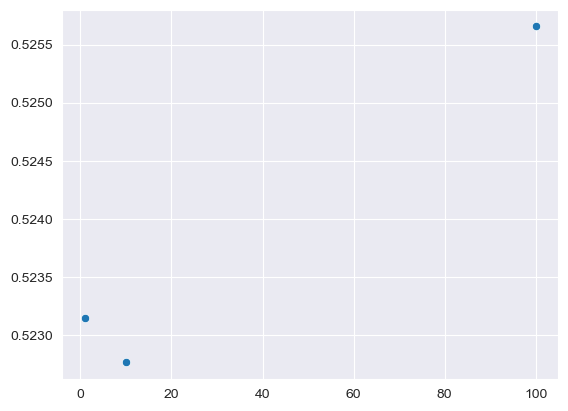

In [139]:
def plot_cv_results(gridsearch):
    params = [x['model__min_samples_leaf'] for x in gridsearch.cv_results_['params']]
    sns.scatterplot(x=params, y=gridsearch.cv_results_['mean_test_score'])

plot_cv_results(search)


In [140]:
X, y = df, label_pipeline.fit_transform(df)
X_train, X_test, y_train, y_test = train_test_split(X, y)
non_linear_model.fit(X_train, y_train)
non_linear_model.score(X_test, y_test)

0.5319460155468444